# Recommender Systems with Surprise Library

## Problem Statement:

Datasource: https://grouplens.org/datasets/movielens/100k/

### What's in the store?
- Exploratory Data Analysis
- Feature Engineering
- User based Collaborative Filtering Recommender System using Surprise Library
- Model Evaluation (RMSE, MAE)

Note: Expecting to expand this Kernel with other Recommender systems in future :) Please suggest improvements and corrections in the comments section.

## Info about the dataset

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC  

u.genre    -- A list of the genres.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.
              
u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

## Load the necessary libraries

In [1]:
#Importing the life-savers

import numpy as np # linear algebra
import pandas as pd # data processing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Suprise Library for Recommendation Model Building
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import BaselineOnly, Reader, Dataset

from surprise.model_selection import cross_validate, train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movielens100k/u.data
/kaggle/input/movielens100k/u.item
/kaggle/input/movielens100k/u.user
/kaggle/input/movielens100k/u.genre


## Exploratory Data Analysis

In [2]:
#Loading the genre dataset. Please note the different encoder used.
genrecols = ['Genre','Genre_Id']
genredf = pd.read_csv("/kaggle/input/movielens100k/u.genre", sep = '|', encoding = 'latin-1', names = genrecols,parse_dates = True)
genredf.set_index("Genre_Id", inplace = True)
genredf.head(20).T

Genre_Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Genre,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western


In [3]:
#Saving the list of genres into a list for further use
genres = genredf['Genre'].values.tolist()
genres

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [4]:
#Loading the item dataset. Please note the different encoder used. Also first 5 columns alone are chosen and remaining are ignored as it has irrelevant data.
itemcols = ['Movie_Id','Title','Release_Date','Video_Release_Date','IMDb_Url']
itemcols_genres = itemcols + genres
itemdf = pd.read_csv("/kaggle/input/movielens100k/u.item", sep = '|', encoding = 'latin-1', names = itemcols_genres, parse_dates = True)
itemdf.head()

,Movie_Id,Title,Release_Date,Video_Release_Date,IMDb_Url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
#Loading the user dataset. Please note the different encoder used.
usercols = ['User_Id','Age','Gender','Profession','Zipcode']
userdf = pd.read_csv("/kaggle/input/movielens100k/u.user", sep = '|', encoding = 'latin-1', names = usercols,parse_dates = True)
userdf.head()

,User_Id,Age,Gender,Profession,Zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


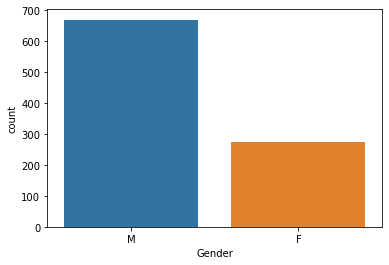

In [6]:
sns.countplot(userdf["Gender"])
plt.show()

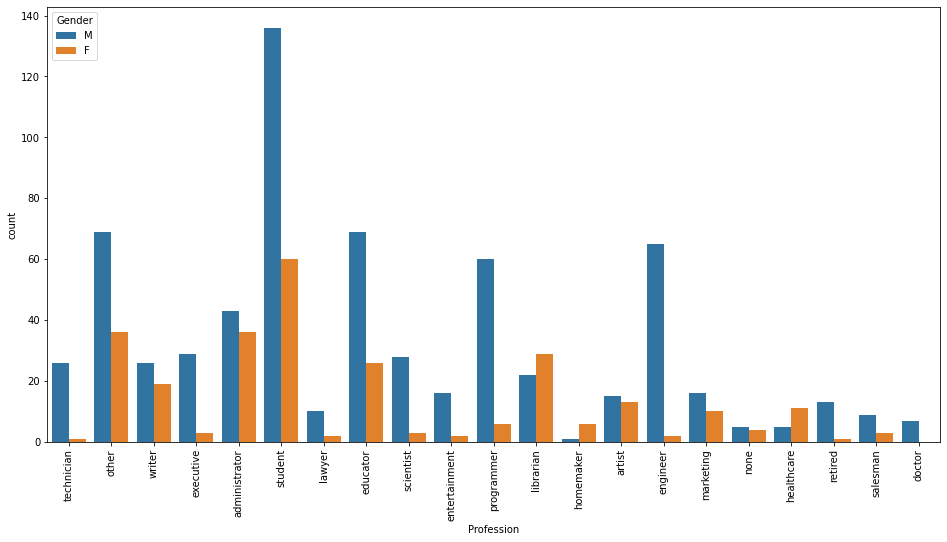

In [7]:
plt.figure(figsize = (16,8))
sns.countplot(userdf["Profession"], hue = userdf["Gender"])

plt.xticks(rotation = 90)
plt.show()

In [8]:
#Loading the data dataset. Please note the different encoder used.
ratingcols = ['User_Id', 'Movie_Id', 'Rating', 'Timestamp']
ratingsdf = pd.read_csv("/kaggle/input/movielens100k/u.data", sep = '\t', encoding = 'latin-1', names = ratingcols, usecols = range(3), parse_dates = True)
ratingsdf.head()

,User_Id,Movie_Id,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


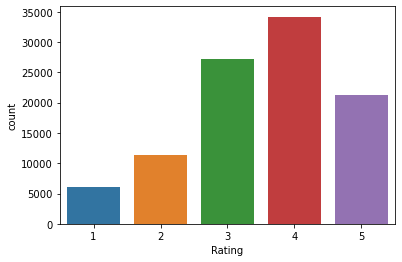

In [9]:
sns.countplot(ratingsdf["Rating"])
plt.show()

In [10]:
#Merging all three dataframes to form our Master dataframe
movies = pd.merge(pd.merge(itemdf, ratingsdf),userdf)
movies.head()

,Movie_Id,Title,Release_Date,Video_Release_Date,IMDb_Url,unknown,Action,Adventure,Animation,Children's,...,Sci-Fi,Thriller,War,Western,User_Id,Rating,Age,Gender,Profession,Zipcode
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,308,4,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,308,5,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,1,0,0,308,4,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,1,0,0,0,308,4,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,308,5,60,M,retired,95076


In [11]:
#Setting the Movie_Id as row index
movies.set_index("Movie_Id", inplace = True)
movies.head(3)

,Title,Release_Date,Video_Release_Date,IMDb_Url,unknown,Action,Adventure,Animation,Children's,Comedy,...,Sci-Fi,Thriller,War,Western,User_Id,Rating,Age,Gender,Profession,Zipcode
Movie_Id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,308,4,60,M,retired,95076
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,308,5,60,M,retired,95076
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,1,0,0,308,4,60,M,retired,95076


## Feature Engineering

In [12]:
#Converting date_added as Pandas DateTime type
movies["Release_Date"] = pd.to_datetime(movies["Release_Date"])

#Deriving Year, Month, Date from date_added
movies["release_year"] = movies["Release_Date"].dt.year
movies["release_month"] = movies["Release_Date"].dt.month
movies["release_date"] = movies["Release_Date"].dt.day #Day of the month
movies["release_day"] = movies["Release_Date"].dt.dayofweek #The day of the week with Monday=0, Sunday=6.
movies.head()

,Title,Release_Date,Video_Release_Date,IMDb_Url,unknown,Action,Adventure,Animation,Children's,Comedy,...,User_Id,Rating,Age,Gender,Profession,Zipcode,release_year,release_month,release_date,release_day
Movie_Id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,308,4,60,M,retired,95076,1995.0,1.0,1.0,6.0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,308,5,60,M,retired,95076,1995.0,1.0,1.0,6.0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,308,4,60,M,retired,95076,1995.0,1.0,1.0,6.0
7,Twelve Monkeys (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,...,308,4,60,M,retired,95076,1995.0,1.0,1.0,6.0
8,Babe (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,...,308,5,60,M,retired,95076,1995.0,1.0,1.0,6.0


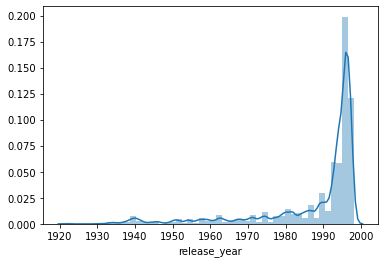

In [13]:
#Distribution of movie releases per calendar year. 
#We can see the humongous growth the movie industry has seen from 1990 onwards
sns.distplot(movies["release_year"])
plt.show()

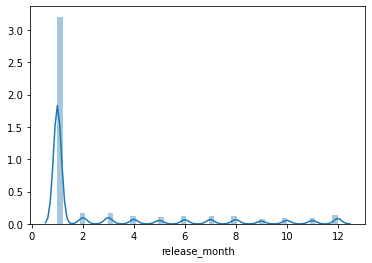

In [14]:
#Distribution of movie releases - monthwise. 
#We can see the majority of the movies releases in January-February period
sns.distplot(movies["release_month"])
plt.show()

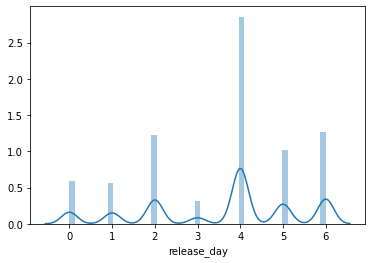

In [15]:
#Distribution of movie releases - monthwise. 
#We can see the majority of the movies releases on Friday (4) followed by Saturday(5) & Sunday(6) weekend
sns.distplot(movies["release_day"])
plt.show()

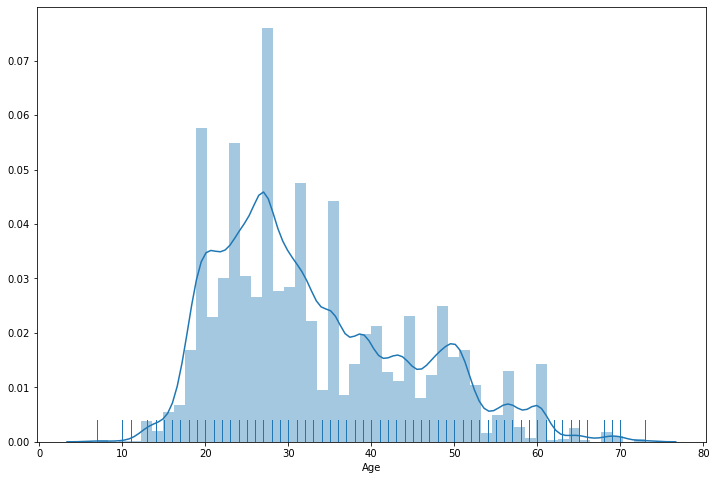

In [16]:
#Distribution of age groups. 
#We can see huge skyscrapers in the range of 18 to 35 years
plt.figure(figsize = (12,8))
sns.distplot(movies["Age"], rug = True)
plt.show()

Visualize how popularity of Genres has changed over the years. From the graph one should be able to see for any given year, movies of which genre got released the most.

In [17]:
movies.columns

Index(['Title', 'Release_Date', 'Video_Release_Date', 'IMDb_Url', 'unknown',
       'Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'User_Id',
       'Rating', 'Age', 'Gender', 'Profession', 'Zipcode', 'release_year',
       'release_month', 'release_date', 'release_day'],
      dtype='object')

In [18]:
genre_map = movies.groupby('release_year').sum()
genre_map = genre_map.drop(columns = ['unknown','Video_Release_Date','User_Id','Rating','Age','release_month', 'release_date', 'release_day']).T
genre_map

release_year,1922.0,1926.0,1930.0,1931.0,1932.0,1933.0,1934.0,1935.0,1936.0,1937.0,...,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0
Action,0,0,0,0,0,0,0,0,0,0,...,948,579,456,684,1675,1741,2328,4573,5674,220
Adventure,0,0,0,0,0,0,0,0,0,0,...,746,256,161,142,724,878,1018,2793,1963,62
Animation,0,0,0,0,0,0,0,0,0,172,...,0,0,202,285,118,244,550,748,164,0
Children's,0,0,0,0,0,0,0,0,0,172,...,0,137,202,219,347,605,1118,1038,775,3
Comedy,0,0,0,0,0,93,96,22,27,18,...,521,624,172,671,2515,3524,3641,5798,4480,281
Crime,0,0,0,44,0,0,0,0,0,0,...,201,316,0,445,384,784,1143,1035,2340,95
Documentary,0,0,0,0,0,0,0,0,0,0,...,0,29,17,0,38,222,23,232,99,10
Drama,0,2,18,0,0,0,5,0,12,34,...,1263,970,904,546,2662,3787,4677,8513,6700,531
Fantasy,0,0,0,0,0,0,0,0,0,0,...,0,0,24,0,0,211,157,458,96,3
Film-Noir,0,0,0,44,0,0,0,0,0,0,...,0,89,0,0,4,0,57,82,370,30


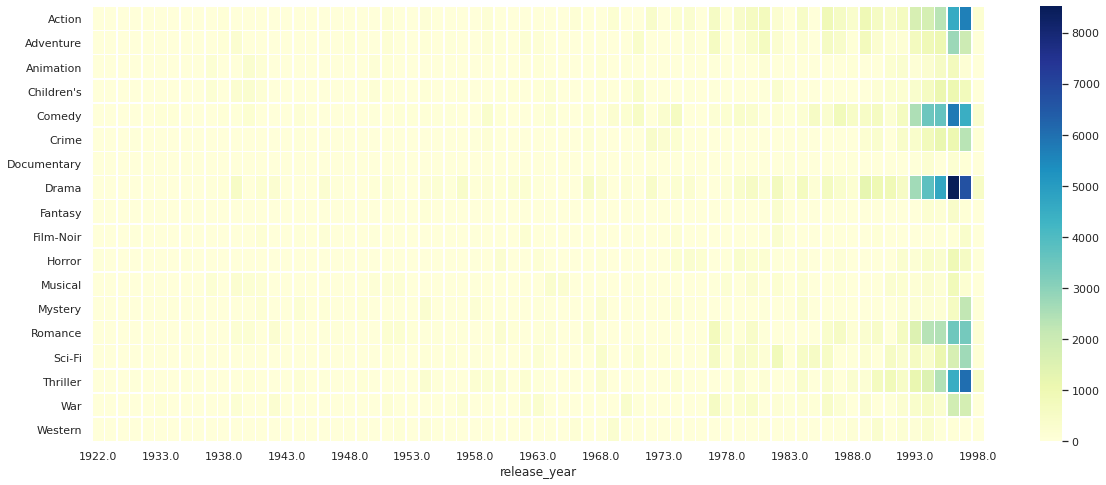

In [19]:
#Plotting the heatmap of the above grouped dataset to understand the distribution over the years
plt.figure(figsize = (20,8))
sns.set()
sns.heatmap(genre_map, cmap = 'YlGnBu', linewidths = 0.5, xticklabels = 5, cbar_kws={"orientation": "vertical"})
plt.show()

In [20]:
#!pip install WordCloud

In [21]:
from wordcloud import WordCloud, STOPWORDS

In [22]:
stopwords = set(STOPWORDS)

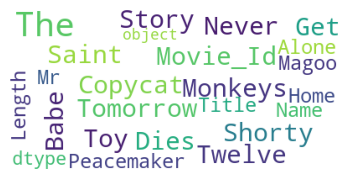

In [23]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(movies['Title']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [24]:
movies.head()

,Title,Release_Date,Video_Release_Date,IMDb_Url,unknown,Action,Adventure,Animation,Children's,Comedy,...,User_Id,Rating,Age,Gender,Profession,Zipcode,release_year,release_month,release_date,release_day
Movie_Id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,308,4,60,M,retired,95076,1995.0,1.0,1.0,6.0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,308,5,60,M,retired,95076,1995.0,1.0,1.0,6.0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,308,4,60,M,retired,95076,1995.0,1.0,1.0,6.0
7,Twelve Monkeys (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,...,308,4,60,M,retired,95076,1995.0,1.0,1.0,6.0
8,Babe (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,...,308,5,60,M,retired,95076,1995.0,1.0,1.0,6.0


## Model Building using Suprise Library

In [25]:
user_item_df = pd.read_csv('/kaggle/input/movielens100k/u.data', sep='\t')
user_item_df.head()

,196,242,3,881250949
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,298,474,4,884182806


In [26]:
file_path = os.path.expanduser('/kaggle/input/movielens100k/u.data')

reader = Reader(line_format='user item rating timestamp', sep='\t')

data = Dataset.load_from_file(file_path, reader=reader)

cross_validate(BaselineOnly(), data, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9434  0.9495  0.9467  0.9399  0.9425  0.9444  0.0033  
MAE (testset)     0.7482  0.7524  0.7498  0.7461  0.7471  0.7487  0.0022  
Fit time          0.27    0.31    0.30    0.30    0.29    0.29    0.01    
Test time         0.39    0.17    0.17    0.17    0.32    0.24    0.09    


{'test_rmse': array([0.94336938, 0.94945014, 0.94668414, 0.93990716, 0.94250627]),
 'test_mae': array([0.74821564, 0.75239521, 0.74983931, 0.74608886, 0.74712063]),
 'fit_time': (0.27089381217956543,
  0.3061206340789795,
  0.29756832122802734,
  0.30243921279907227,
  0.29463720321655273),
 'test_time': (0.3915126323699951,
  0.16983294486999512,
  0.17074275016784668,
  0.17021703720092773,
  0.31826257705688477)}

In [27]:
trainset, testset = train_test_split(data, test_size=0.20)

In [28]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## Model Prediction

In [29]:
# we can now query for specific predicions
uid = str(196)  # raw user id
iid = str(302)  # raw item id

In [30]:
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 196        item: 302        r_ui = None   est = 3.96   {'actual_k': 50, 'was_impossible': False}


In [31]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [32]:
test_pred

[Prediction(uid='714', iid='117', r_ui=5.0, est=4.032985423258754, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='116', iid='661', r_ui=4.0, est=3.5552452906559835, details={'actual_k': 37, 'was_impossible': False}),
 Prediction(uid='5', iid='408', r_ui=5.0, est=4.011177751407121, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='535', iid='962', r_ui=4.0, est=3.2950691643171846, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid='860', iid='220', r_ui=3.0, est=2.3938859108874047, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid='334', iid='888', r_ui=2.0, est=3.2320043585767224, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid='804', iid='631', r_ui=3.0, est=3.31074097438637, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='64', iid='847', r_ui=3.0, est=4.01049312258337, details={'actual_k': 25, 'was_impossible': False}),
 Prediction(uid='910', iid='56', r_ui=4.0, est=3.77

## Model Evaluation

In [33]:
#RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 0.9365


0.9365319883553841

In [34]:
#MAE
print("User-based Model : Test Set")
accuracy.mae(test_pred, verbose=True)

User-based Model : Test Set
MAE:  0.7306


0.7305847242876471